# Определение эмоциональной окраски твитов с помощью BERT

Решим достаточно простую, но интересную задачу: будем определять эмоциональную окраску твитов с помощью BERT. Для дообучения BERT на такую простую задачу не потребуется много вычислительных ресурсов — при желании, можно дообучить сеть даже на CPU. Итак, мы возьмём предобученный BERT и добавим к нему слой нейронов, чтобы обучить полученную модель для классификации предложений. Возникает резонный вопрос — если, в среднем, файнтюнинг BERT занимает много времени и много ресурсов, зачем же нам это нужно, если можно взять, и с нуля обучить какую-нибудь сеть (например, LSTM) для решения той же самой задачи? Давайте отвечать на этот вопрос постепенно. Во-первых, веса BERT уже содержат много информации о том, как устроен язык. А значит, на файнтюнинг модели уйдёт совсем немного времени. Авторы статьи про BERT советуют запускать всего от двух до четырёх эпох, чтобы получить хороший результат. Кроме того, для файнтюринга нам нужно достаточно мало данных — небольшого количества данных, зачастую, оказывается достаточно, чтобы получить хорошие результаты. Ну, ещё одна причина немаловажная. Один и тот же BERT (одну и ту же сеть с одними и теми же весами) можно использовать как основу для дообучения для совершенно разных задач, начиная от классификации и заканчивая вопросно-ответными системами или машинным переводом, или чем-то ещё. 

Немного повторим теорию про BERT. Выберите правильные утверждения:

-BERT обучается только на задаче маскированного языкового моделирования: 15 процентов токенов заменяются на токен [MASK] (эти выбираются произвольно), а BERT пытается предсказать эти слова, учитывая немаскированный контекст

-Для каждого языка нужно использовать особую версию BERT, предобученную на текстах, написанных только на выбранном языке

-Для решения задач классификации текстов и перевода предложений с английского на русский нужно обязательно использовать разные предобученные модели, так как задачи сильно отличаются друг от друга

+Во время обучения BERT используется два подхода: маскированное языковое моделирование (Mask Language Model) и определение, является ли второе предложение логически связанным с первым (Next Sentence Prediction)

Сегодня мы не будем кодить руками обучение BERT, а покажем, как, максимально просто, максимально быстро, найти готовый предобученный BERT и, минимальным количеством кода, дофайнтюнить его для решения вашей задачи. Это значит что мы будем использовать готовые библиотеки. Одна из них называется pytorch-transformers. В ней есть pytorch-интерфейс BERT, а также в этой библиотеке есть удобные обёртки и для других популярных моделей (например, для XL трансформера, или GPT-2, или каких-то других моделей — например, для RoBERTa[2]). На сегодняшний день, пожалуй, эта библиотека является самой популярной обёрткой для удобного использования BERT. Ещё про эту библиотеку хочется отметить, что в ней есть не только удобное выкачивание предобученного BERT, но и специальные модификации для конкретных задач. Например, для задачи классификации предложений (классификации текстов), которую мы собственно и будем использовать.  

## Установка библиотек

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')
# !pip install pytorch-transformers
# !pip install keras
# !pip install tensorflow 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060


## Загрузка данных


Дальше посмотрим на данные, на которых мы будем дообучать нашу модель. Мы выбрали достаточно интересный датасет с разметкой сентимента русскоязычных твитов.[1] Корпус содержит около 115 тысяч записей с положительной эмоциональной окраской и около 112 000 — с отрицательной эмоциональной окраской. И этот датасет был размечен вручную. Давайте посмотрим на наши данные. Загружаем наши тексты и смотрим на произвольные 5 записей. Как вы видите, лексика здесь достаточно неформальная, ну собственно, как в твитах. Есть какие-то слова (вот такие, например) забавные, есть смайлики.  

Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [3]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
5321,409063006149279744,1386363195,YarikOfficial,Невероятных снов вам ! Как мне вчера ночью или...,1,0,0,0,3958,356,74,4
80114,410740357807476736,1386763107,malinina_00,"@marina1999_81 несиии уж, только принесу через...",1,0,0,0,2450,25,16,0
19673,409406708235005952,1386445140,Sergey_Styepin,"@Varfolomeev она там все уравновесила ""белой о...",1,0,0,0,29008,707,74,22
22383,409433368632504320,1386451496,zibrov_yuriy,RT @ciao_lucine: Эх... Люблю же я ересь в лент...,1,0,1,0,949,46,44,0
30656,409644758488068096,1386501895,MazaevMaxim,"Очень важная победа в конце года) привет, пере...",1,0,0,0,1139,53,50,0


Теперь давайте приготовим наши данные так, чтобы их можно было подать в BERT для дообучения. Обратите внимание на специальные токены — "CLS" и "SEP", которые мы будем добавлять в начало и конец наших предложений. Как вы помните, именно такой формат нужен BERT для того, чтобы работать с входными предложениями. Посмотрим, что всё у нас нормально — все размерности сошлись, и распечатаем пример — ну, например, 1000-ое предложение. Видим какой-то твит — в начале метка "CLS", в конце — метка "SEP".  

In [4]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]

assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]
print(sentences[1000])

[CLS] Дим, ты помогаешь мне, я тебе, все взаимно, все правильно) [SEP]


Теперь поделим наши данные на обучающую выборку и холдаут (holdout) — то есть, некоторые данные отложим и не будем их использовать в процессе дообучения, а затем на этой отложенной выборке померим качество нашей дообученной модели. Делим наши данные в пропорции 70/30%, смотрим, какие данные у нас получились: в обучающей выборке примерно 158 000 записей, а в холдауте 68 000.  

[1] Корпус коротких текстов Юлии Рубцовой: http://study.mokoron.com/  
[2] Liu Y. et al. Roberta: A robustly optimized bert pretraining approach //arXiv preprint arXiv:1907.11692. – 2019.

In [5]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Теперь импортируем токенизатор для BERT, который превратит наши тексты в набор токенов, соответствующих тем, что встречались в словаре предобученной модели. Импортируем из pytorch-transformers "bert_tokenizer" и затем загрузим модель, которая называется "bert_base_uncased". Это означает, что мы используем токенизатор для модели BERT Base — это та самая модель, которая меньше, чем BERT Large, и содержит внутри 12 self-attention модулей. "Uncased" означает, что все слова в словаре этого токенайзера написаны в нижнем регистре (то есть, все слова написаны с маленькой буквы). Посмотрим, на какие токены наш токенайзер разобьёт, ну, например, первое предложение из наших данных. BERT требует специальный формат входных данных. Нам нужно предоставить четыре сущности. Первая называется input_ids — это последовательность чисел, которая отождествляет каждый токен с его номером в словаре. Вторая сущность называется labels — это вектор из нулей и единиц. В нашем случае, нули и обозначают негативную эмоциональную окраску, а единицы — положительную эмоциональную окраску. А ещё есть две сущности, два параметра, не обязательных. Они называются segment_mask и attention_mask. segment_mask — это последовательность нулей и единиц, которая показывает, состоит ли наш входной текст из двух предложений или из одного. Соответственно, в случае одного предложения, мы просто подаём вектор из одних нулей. Как вы помните, BERT предобучается на двух задачах. Первая задача — это предсказание маскированных слов в тексте, а вторая задача — определение, является ли одно предложение продолжением другого предложения. И, соответственно, для того, чтобы дать BERT информацию о том, есть ли у нас два предложения в нашем входе, либо одно, нам нужен этот параметр segment_mask. Следующий параметр (attention mask) — это также последовательность нулей и единиц, где единицы обозначают токены предложения, а нули — паддинг. Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Ну, например, в нашем случае, мы можем сказать, что максимальная длина предложения у нас будет равна 100, можно выбрать какую-то другую длину, это не сильно важно. И теперь более длинные предложения мы будем обрезать до 100 токенов, а для более коротких предложений использовать паддинг. Для того, чтобы добавить паддинг нашим предложениям, мы будем использовать готовую функцию из keras под названием pad_sequences. 

In [6]:
from transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'о', '##ч', '##е', '##н', '##ь', 'с', '##к', '##у', '##ч', '##а', '##ю', 'п', '##о', 'т', '##в', '##и', '##т', '##а', '##м', 'и', 'ч', '##е', '##к', '##и', '##на', '##м', '@', 'ko', '_', 'omar', '##off', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Первое предложение из нашей обучающей выборки разбилось на токены, почти все токены здесь состоят из одной буквы, но встречаются иногда и двухбуквенные токены, иногда встречаются символы пунктуации.

Здесь написан код, который добавляет паддинг к нашим предложениям. 


In [7]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Теперь нам нужно поделить наши данные на тренировку и валидацию. Отложенную выборку мы уже отложили в переменную test_data или test_sentences, и теперь давайте поделим оставшийся данные на обучение и валидацию. Делаем мы это точно так же, с помощью функции train_test_split, делим в пропорции 90% оставшихся данных — на обучение, 10% — на валидацию. 

In [8]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Дальше мы превращаем наши данные в pytorch тензоры, и давайте посмотрим на формат, в котором у нас лежат наши лэйблы. Обратите внимание на формат лейблов в наших данных. Мы подаём не просто list() из нулей и единиц, а мы подаём list(list()). Это нужно для того, чтобы поддерживать также возможность работы с задачами, где мы каждому объекту присваиваем несколько классов. Например, если бы мы хотели присваивать некоторые метки (лейблы) тем для наших предложений (ну, или скорее для наших текстов), то мы хотели бы уметь присваивать несколько тем одному тексту. В нашем же более простом случае, у каждого предложения есть только одна метка — положительная или отрицательная эмоциональная окраска. Но, тем не менее, данные мы подаём в таком формате. 

In [9]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_labels

tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [1],
        [1]])

Нужно создать итераторы с помощью DataLoader. Данные по батчам мы будем разбивать произвольно с помощью RandomSampler. Разбитие данных на батчи позволит нам более эффективно использовать память во время обучения, поскольку нам не придётся загружать весь датасет в память. И, также, обратите внимание на размер батча. Здесь мы пишем число "32", но, если вы обнаружите, что во время тренировки у вас появляется, "memory error" — значит, можно попробовать уменьшить размер батча (все как обычно).

In [10]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

Вы подаете на вход BERTу segment_mask = [0,0,0,0,0,0,0] и attention_mask = [1,1,1,1,1,1,1,0,0,0]. Выберите верные утверждения:

+Вы подаете на вход одно предложение  

-Предложение имеет положительную эмоциональную окраску с вероятностью 70%  

-Максимально возможная длина входа равна 10 символам  

-Для этого инпута паддинг не используется, предложение и так имеет максимально возможную длину  

-В словаре содержится 10 токенов  

+Максимально возможная длина входа равна 10 токенам  

## Обучение модели

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации. А затем — дофайнтюнить полученную сеть на наших данных. Мы берём готовую модификацию BERT для классификации из pytorch-transformers, она называется "BertForSequenceClassification". Импортируем её. Это обычный BERT с добавленным одним линейным слоем для классификации. Аналогичные модели есть и для решения других задач, например, есть "BertForQuestionAnswering", есть "BertForTokenClassification". Все эти модели построены на основе одной и той же архитектуры и различаются только верхними слоями. Рассмотрим сам процесс файнтюнинга. Как мы помним, первый токен в каждом предложении в наших данных — это метка "CLS". Скрытое состояние, относящееся к этой метке, должно содержать в себе агрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом должен быть вектор со скрытым состоянием, относящийся к метке "CLS". Дополнительный полносвязный слой, который мы добавили, имеет размер ["hidden state", "количество классов"] — это двухмерный вектор. В нашем случае, количество классов равно "2", то есть, на выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска", "отрицательная эмоциональная окраска". По факту, мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях. Иногда некоторые слои специально замораживают или применяют разные стратегии работы с learning rate. В общем делают всё, чтобы сохранить хорошие веса в нижних слоях и ускорить процесс дообучения. В целом, замораживание слоёв BERT обычно не сильно сказывается на итоговом качестве, однако стоит помнить о тех случаях, когда домен для предобучения и дообучения был разным. Например, когда мы предобучили нашу сеть на каких-то официальных текстах (на правовых актах или на научных статьях), а дообучаем её на, например, твитах, на неформальной лексике. В таких случаях лучше тренировать все слои сети, не замораживая ничего.


Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [11]:
from transformers import AdamW, BertForSequenceClassification

# Аналогичные модели есть и для других задач:
from transformers import BertForQuestionAnswering, BertForTokenClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Отлично, теперь давайте обсудим гиперпараметры для обучения нашей модели. Авторы статьи про BERT советуют выбирать learning rate из следующего списка: 5\*10^(-5), 3\*10^(-5), 2\*10^(-5). А количество эпох делать не слишком большим (2 или 4 будет достаточно). Мы же пробуем дообучать нашу сеть за одну эпоху, а в качестве learning rate давайте выберем 2\*10^(-5). Вы можете попробовать другие параметры и убедиться, что это не слишком сильно повлияет на итоговое качество вашей модели. 

In [12]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/home/dmitry/anaconda3/envs/stpk_nlp/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Что происходит в коде с циклом обучения. Цикл в нашем случае весьма номинален, поскольку он состоит из всего одной итерации. Вот наш код для дообучения модели. В процессе обучения, сначала мы переводим нашу модель в train mode, затем распаковываем входные данные — распаковываем вектор с индексами токенов и метки классов. Затем не забываем очистить градиенты с прошлого шага с помощью zero_grad(). Делаем forward pass, считаем loss, затем делаем backward pass, считаем градиенты, и дальше — стандартно — делаем optimizer.step(). Кроме того, в процессе обучения мы будем рисовать график и считать лосс. В конце каждой эпохи (в нашем случае — в конце единственной эпохи) посчитаем лосс на нашей обучающей выборке

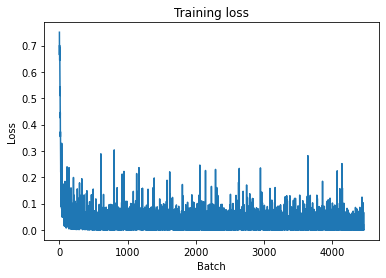

Loss на обучающей выборке: 0.03692
CPU times: user 20min 57s, sys: 31.7 s, total: 21min 29s
Wall time: 21min 26s


In [13]:
%%time
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))




По графику видно, что лосс, с первых батчей, достаточно сильно просел, потом сильно не менялся, но достаточно сильно флуктуировал. 

Теперь посмотрим, какое качество мы можем получить на наших валидационных данных после одной эпохи. Вот наш код для валидации. Сначала переводим нашу модель в evaluation mode. Также, как в процессе обучения, распаковываем наш батч, загружаем данные на GPU, скармливаем данные сети (то есть делаем forward pass) и считаем лосс на валидационных данных (мониторим прогресс). Также — обратите внимание — мы используем torch.no_grad, при этом модель не будет считать и хранить градиенты, это ускорит процесс предсказания меток для наших валидационных данных. И давайте посмотрим, что у нас получилось, какой score у нас получился на валидационных данных. Процент правильных предсказаний на валидационной выборке составил 97.87%. Кажется, вполне неплохо всего для одной эпохи дообучения и 15-20 минут обучения на одной GPU. 

In [14]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 98.31%
Процент правильных предсказаний на валидационной выборке: 98.31%


# Оценка качества на отложенной выборке

Теперь оценим качество нашей модели на отложенной выборке. Для этого нам нужно сделать точно такую же предобработку наших тестовых данных, как мы делали для обучающей и валидационной выборки. По сути, мы просто копируем два кусочка кода из предыдущих частей ноутбука. Делаем токенизацию тем же самым токенайзером, готовим переменные input_ids, добавляем паддинг, делаем attention-маски. И, затем, запускаем код, который посчитает нам accuracy на наших тестовых данных.  

In [15]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [16]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [17]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

Процент правильных предсказаний на отложенной выборке составил 98% (если точнее, 98.12%). Очень похоже на то, что получилось на валидационной выборке. Чуть точнее — у нас оказалось всего около 1300 неправильных предсказаний из 68 тысяч. Для такого недолгого и простого процесса дообучения это очень и очень здорово.

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 98.11%


In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(np.array(test_labels) != test_preds),
    len(test_labels)
))

Неправильных предсказаний: 1285/68051


Мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Кроме того, обратите внимание, что мы не тюнили параметры и использовали сравнительно маленький размеченный корпус, чтобы получить accuracy больше 98%. Тем не менее, если не делать дообучение под конкретную задачу вовсе, то получить хорошее качество вряд ли выйдет. Кроме того, на этом семинаре мы познакомились с библиотекой pytorch-transformers, которая позволяет использовать готовые обёртки над моделями, специально созданными для решения той или иной задачи. Использовать BERT при решении повседневных NLP задач совсем не трудно. Не нужно даже вручную скачивать веса модели, искать их где-то в интернете — библиотека абсолютно всё сделает за вас. Отбросив необходимость небольшой предобработки текстов, сложность применения предобученного BERT с использованием библиотеки pytorch-transformers оказывается не сильно больше, чем — ну, например, импортировать лог-регрессию из sk-learn, и примените её, а качество итоговое получается гораздо выше. Вы можете использовать предобученный BERT, GPT-2 или какие-то другие сети для решения других задач — не только классификации, но и чего-то более сложного, например, для решения задачи вопросно-ответного поиска, или, может быть, машинного перевода или выделения именованных сущностей. Единственное, что вам нужно будет сделать — это импортировать другую модель из pytorch-transformers и подготовить ваши данные для обучения в чуть-чуть другом формате.

### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [ ]:
import pandas as pd

dataset = pd.read_csv('datasets/bert_sentiment_analysis/homework/IMDB_Dataset.csv')
dataset.head()

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?